<a href="https://colab.research.google.com/github/jaeofbum/-ViT-/blob/main/KD(ResNet50_and_DeiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.7 MB/s 


In [ ]:
#자료 타입을 리스트로 선언
from typing import List
#텐서플로우 불러오기
import tensorflow as tf
#텐서플로우로도 연산을 할수없는것을 구현해야되기때문에 아돈스 API 불러오기
import tensorflow_addons as tfa
#케라스 모델(ResNet50)불러오기위해 케라스 불러오기
from tensorflow import keras as keras
#모델을 만들기 위해 불러오기
from tensorflow.keras.models import Sequential
#레이어 만들기 위해 불러오기
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Dense
tf.random.set_seed(42)
import h5py
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 100
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 2

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [ ]:
def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 2 if "distilled" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

In [ ]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

In [ ]:
class ViTDistilled(ViTClassifier):
    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training

        # CLS and distillation tokens, positional embedding.
        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append the tokens.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier
            # predictions.
            return (x + x_dist) / 2

        elif training:
            # Only return separate classification predictions when training in distilled
            # mode.
            return x, x_dist

In [ ]:
#제대로 나오는지 더미 넣어서 확인
deit_tiny_distilled = ViTDistilled()

dummy_inputs = tf.ones((2, 224, 224, 3))
outputs = deit_tiny_distilled(dummy_inputs, training=False)
print(outputs.shape)

(2, 2)


In [ ]:
deit_tiny_distilled.load_weights("/content/drive/MyDrive/Colab Notebooks/deit1.h5")

In [ ]:
class DeiT(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        # Forward pass of teacher
        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), -1)
        teacher_predictions = tf.argmax(teacher_predictions, -1)

        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)

            # Compute losses.
            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )
            loss = (student_loss + distillation_loss) / 2

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)

In [ ]:
#학습할 포트홀 이미지 이미지 제너레이터로 학습,확인,테스트로 나누기
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1/255)
# Test ImageDataGenerator
test_gen = ImageDataGenerator(rescale=1/255.)
# valid ImageDataGenerator
valid_gen = ImageDataGenerator(rescale=1/255.)

train_flow_gen = train_gen.flow_from_directory(directory='/content/drive/MyDrive/Colab Notebooks/classification/train',
                                            target_size=(224, 224),  
                                            class_mode='categorical',
                                            batch_size=16,
                                            shuffle=True)
valid_flow_gen = valid_gen.flow_from_directory(directory='/content/drive/MyDrive/Colab Notebooks/classification/val',
                                            target_size=(224, 224), 
                                            class_mode='categorical',
                                            batch_size=16,
                                            shuffle=False)
test_flow_gen = test_gen.flow_from_directory(directory='/content/drive/MyDrive/Colab Notebooks/classification/test',
                                            target_size=(224, 224), 
                                            class_mode='categorical',
                                            batch_size=16,
                                            shuffle=False)

Found 394 images belonging to 2 classes.
Found 132 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


In [ ]:
#모델 컴파일 하기
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_student_loss",
    patience=2,
    mode="auto",
    restore_best_weights=True,
)
#ResNet50모델 사전학습한거 불러오기(교사모델)
resnet50 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/resnet50 yjb.h5', custom_objects=None, compile=True, options=None)
    # deit_tiny_distilled = ViTDistilled()
deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher=resnet50)
lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
         optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
         metrics=["accuracy"],
         student_loss_fn=keras.losses.CategoricalCrossentropy(
             from_logits=True, label_smoothing=0.1),
         distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
#DeiT모델 구조 보기
deit_distiller.student.summary()

Model: "vi_t_distilled_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection (Sequential)     (None, 196, 192)          147648    
                                                                 
 transformer_block_0 (Functi  (None, 198, 192)         740928    
 onal)                                                           
                                                                 
 transformer_block_1 (Functi  (None, 198, 192)         740928    
 onal)                                                           
                                                                 
 transformer_block_2 (Functi  (None, 198, 192)         740928    
 onal)                                                           
                                                                 
 transformer_block_3 (Functi  (None, 198, 192)         740928    
 onal)                                            

In [ ]:
#Knowledge Distillation을 사용해서 ResNet50(교사모델)로 DeiT모델 학습시키기
deit_distiller.fit(train_flow_gen,callbacks=[callback], validation_data=valid_flow_gen, epochs=5)
deit_distiller.student.compile( optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=["accuracy"], loss=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ))
deit_distiller.student.evaluate(test_flow_gen)
deit_distiller.student.save_weights('/content/drive/MyDrive/Colab Notebooks/deit39.h5')

Epoch 1/5
25/25 [==============================] - 14s 565ms/step - accuracy: 0.9848 - student_loss: 0.2345 - distillation_loss: 0.0673 - val_accuracy: 0.8636 - val_student_loss: 0.4953 - val_distillation_loss: 0.0000e+00
Epoch 2/5
25/25 [==============================] - 13s 534ms/step - accuracy: 0.9873 - student_loss: 0.2275 - distillation_loss: 0.0462 - val_accuracy: 0.8712 - val_student_loss: 0.5662 - val_distillation_loss: 0.0000e+00
Epoch 3/5
9/9 [==============================] - 5s 308ms/step - loss: 0.9609 - accuracy: 0.7879


In [ ]:
#가장학습이 잘된 가중치 불러오기
deit_tiny.load_weights('/content/drive/MyDrive/Colab Notebooks/deit1.h5')

In [ ]:
#교사모델(ResNet50)의 정확도
deit_distiller.teacher.evaluate(test_flow_gen)

9/9 [==============================] - 96s 12s/step - loss: 0.3213 - accuracy: 0.9091


[0.32133713364601135, 0.9090909361839294]

In [ ]:
#학습이 가장좋은 가중치에 정확도
deit_distiller.student.evaluate(test_flow_gen)

9/9 [==============================] - 3s 302ms/step - loss: 0.5631 - accuracy: 0.8485


[0.5631250739097595, 0.8484848737716675]

In [ ]:
#이미지 프레임으로 잘라서 모델에 넣을꺼 전처리
from tensorflow.keras.preprocessing.image import ImageDataGenerator
detect = ImageDataGenerator(rescale=1/255.)
detect_final = detect.flow_from_directory(directory='/content/drive/MyDrive/1',
                                            target_size=(224, 224),
                                            class_mode='input',
                                            shuffle=False)

Found 13 images belonging to 2 classes.


In [ ]:
#결과 0,1로 나누는 코드
import numpy as np
prediction = deit_tiny_distilled.predict(detect_final)
prediction = np.argmax(prediction, axis=1)

1/1 [==============================] - 2s 2s/step


In [ ]:
#동영상을 이미지로 프레임별로 나눈거 리스트 형식으로 바꾸기
import glob

path = "/content/drive/MyDrive/1/iz/*"
file_list = glob.glob(path)
a = [file for file in file_list if file.endswith(".jpg")]
a.sort()

In [ ]:
#이미지 포트홀인지 아닌지 분류하여 이미지 전처리하기
from google.colab.patches import cv2_imshow
import cv2 as cv
count = 1
 
# k -> a의 값
# v -> prediction의 값
for k,v in zip(a,prediction): 
    if v: # 1인경우
      image = cv.imread(k, cv.IMREAD_UNCHANGED)
      nTop = 10
      nBottom = 10
      nLeft = 10
      nRight = 10
      red =(0, 255, 255)
      CONSTANT = cv.copyMakeBorder(image, nTop, nBottom, nLeft, nRight, 
      borderType=cv.BORDER_CONSTANT,value=red)
      cv2.imwrite(k, CONSTANT)
      new_name = "" + "/content/drive/MyDrive/1/iz/result/"+ str(count) + ".jpg" 
      cv2.imwrite(new_name, image)
      count = count+1
    else: # 0인경우
      image = cv2.imread(k, cv2.IMREAD_UNCHANGED)
      nTop = 10
      nBottom = 10
      nLeft = 10
      nRight = 10
      red =(193, 105, 101)
      CONSTANT = cv.copyMakeBorder(image, nTop, nBottom, nLeft, nRight, 
      borderType=cv.BORDER_CONSTANT,value=red)
      cv2.imwrite(k, CONSTANT)

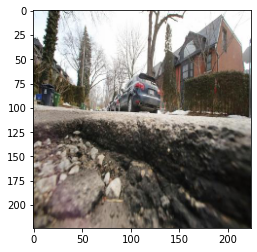

In [ ]:
plt.imshow(img)

In [ ]:
temp_output = deit_distiller.student.predict(test_flow_gen)  

9/9 [==============================] - 4s 310ms/step
